In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
import torch.backends.cudnn as cudnn

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

------------------------------------------------
**Finetuned ResNet101**

In [7]:
# dictionary of channel means and std. devs. for normalization
datasets = {'ORIGA': {'means': [0.8838386, 0.54816394, 0.26245996], 'stds': [0.0874888, 0.11906112, 0.09120588]},
            'REFUGE': {'means': [0.66341796, 0.43719301, 0.29155903], 'stds': [0.16775985, 0.14277969, 0.09243343]},
            'ACRIMA': {'means': [0.72563578, 0.37745064, 0.09958277], 'stds': [0.09922888, 0.10618329, 0.05055466]},
            'RIM-ONE': {'means': [0.58595025, 0.26142626, 0.14453408], 'stds': [0.11523398, 0.09373888, 0.04623389]},
            'ACRIMA_ROI_PCA_10': {'means': [0.72526991, 0.37702303, 0.09916705], 'stds': [0.09851708, 0.10471367, 0.05001943]},
            'RIM-ONE_ROI_PCA_10': {'means': [0.58551604, 0.26098922, 0.14410305], 'stds': [0.11481174, 0.09278062, 0.04551923]},
            'ORIGA_ROI_PCA_10': {'means': [0.88476844, 0.54803911, 0.26190797], 'stds': [0.08525431, 0.11647995, 0.09007599]},
            'REFUGE_ROI_PCA_10': {'means': [0.66280025, 0.43670917, 0.29114295], 'stds': [0.16692023, 0.14118727, 0.09131572]},
            'IMAGENET': {'means': [0.485, 0.456, 0.406], 'stds': [0.229, 0.224, 0.225]}}

# dictionary of best finetuned model paths
paths = {'ACRIMA': '/content/drive/MyDrive/Thesis/trained_models/ResNet101_ACRIMA_Nov19.pt',
         'ORIGA': '/content/drive/MyDrive/Thesis/trained_models/ResNet101_ORIGA_Nov24.pt',
         'REFUGE': '/content/drive/MyDrive/Thesis/trained_models/ResNet101_REFUGE_Nov29.pt',
         'RIM-ONE': '/content/drive/MyDrive/Thesis/trained_models/ResNet101_RIM-ONE_Nov21.pt'}

In [15]:
# Load pre-trained model
finetuned = 'RIM-ONE'
path = paths[finetuned]

model = models.resnet101(weights='DEFAULT')
num_ftrs = model.fc.in_features
num_cls = 2
model.fc = nn.Linear(num_ftrs, num_cls)
model.load_state_dict(torch.load(path))

# Specify layer to retrieve feature embeddings
layer = model._modules.get('avgpool')

model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
# https://becominghuman.ai/extract-a-feature-vector-for-any-image-with-pytorch-9717561d1d4c
# https://stackoverflow.com/questions/63552044/how-to-extract-feature-vector-from-single-image-in-pytorch
# Function to get pre-trained CNN feature embedding for image
def get_vector(img):
    # 1. Create a PyTorch Variable with the transformed image
    t_img = img
    # 2. Create a vector of zeros that will hold our feature vector
    #    The 'avgpool' layer has an output size of *2048*
    my_embedding = torch.zeros([2048])
    # 3. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(o.flatten())
    # 4. Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    # 5. Run the model on our transformed image
    with torch.no_grad():
        model(t_img.unsqueeze(0))
    # 6. Detach our copy function from the layer
    h.remove()
    # 7. Return the feature vector
    return my_embedding


# Function to get array of embeddings for given data
def get_embeddings(train_data):
  size = len(train_data)
  embed_arr = np.zeros((size, 2048))

  for i in range(size):
    img, label = train_data[i]
    emb = get_vector(img)
    embed_arr[i] = emb

  return embed_arr

In [17]:
## TSNE resources:
# https://towardsdatascience.com/visualizing-feature-vectors-embeddings-using-pca-and-t-sne-ef157cea3a42
# https://medium.com/@f.a.reid/image-similarity-using-feature-embeddings-357dc01514f8
# https://github.com/ma-xu/TSNE/blob/master/cifar.py
# https://github.com/albertferre/shelf-product-identifier/blob/main/notebooks/tsne_embeddings_plot.ipynb

sets = ['ACRIMA', 'ORIGA', 'REFUGE', 'RIM-ONE']
embed_dict = {}
tsne_dict = {}
tsne = TSNE(n_components=2)

for dataset in sets:
  train_dir = '/content/drive/MyDrive/Thesis/' + dataset + '_ROI/train/'
  train_data = ImageFolder(train_dir, transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=datasets[finetuned]['means'], std=datasets[finetuned]['stds'])]))

  # obtain feature embeddings for dataset
  embed_arr = get_embeddings(train_data)
  embed_dict[dataset] = embed_arr
  del embed_arr

  # perform t-SNE on each dataset separately
  set_tsne = tsne.fit_transform(embed_dict[dataset])
  tsne_dict[dataset] = set_tsne
  del set_tsne

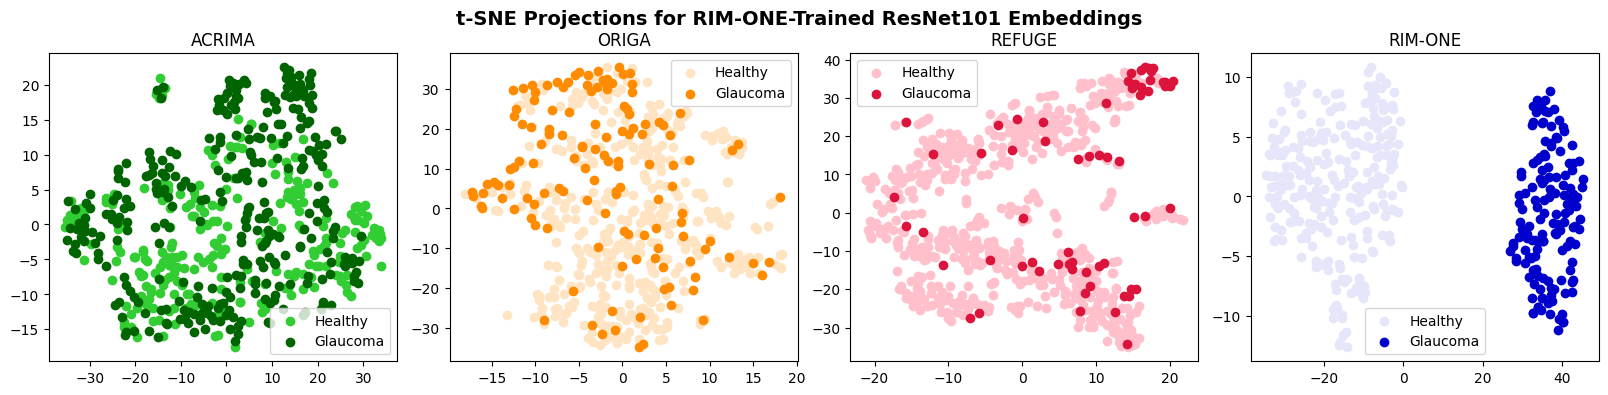

In [18]:
# Subplots for individual dataset embeddings
# [length of 0, length of 1 (total length)]: 250, 314 (564), 388, 132 (520), 580, 64 (644), 251, 141 (392)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20,4))
plt.subplots_adjust(wspace=0.15)

ax1.scatter(tsne_dict['ACRIMA'][0:249, 0], tsne_dict['ACRIMA'][0:249, 1], color='limegreen', label='Healthy')
ax1.scatter(tsne_dict['ACRIMA'][250:563, 0], tsne_dict['ACRIMA'][250:563, 1], color='darkgreen', label='Glaucoma')
ax1.set_title("ACRIMA")
ax1.legend()

ax2.scatter(tsne_dict['ORIGA'][0:387, 0], tsne_dict['ORIGA'][0:387, 1], color='bisque', label='Healthy')
ax2.scatter(tsne_dict['ORIGA'][388:519, 0], tsne_dict['ORIGA'][388:519, 1], color='darkorange', label='Glaucoma')
ax2.set_title("ORIGA")
ax2.legend()

ax3.scatter(tsne_dict['REFUGE'][0:579, 0], tsne_dict['REFUGE'][0:579, 1], color='pink', label='Healthy')
ax3.scatter(tsne_dict['REFUGE'][580:643, 0], tsne_dict['REFUGE'][580:643, 1], color='crimson', label='Glaucoma')
ax3.set_title("REFUGE")
ax3.legend()

ax4.scatter(tsne_dict['RIM-ONE'][0:250, 0], tsne_dict['RIM-ONE'][0:250, 1], color='lavender', label='Healthy')
ax4.scatter(tsne_dict['RIM-ONE'][251:391, 0], tsne_dict['RIM-ONE'][251:391, 1], color='mediumblue', label='Glaucoma')
ax4.set_title("RIM-ONE")
ax4.legend()

fig.suptitle("t-SNE Projections for " + finetuned + "-Trained ResNet101 Embeddings", y=0.99, fontsize=14, fontweight='bold')
plt.savefig('/content/drive/MyDrive/Thesis/t-SNE plots/' + finetuned + '_ResNet.png')
plt.show()

In [19]:
# perform t-SNE on full concatenated array (all datasets)
full_embed_arr = np.concatenate((embed_dict['ACRIMA'], embed_dict['ORIGA'], embed_dict['REFUGE'], embed_dict['RIM-ONE']), axis=0)
embed_tsne = tsne.fit_transform(full_embed_arr)

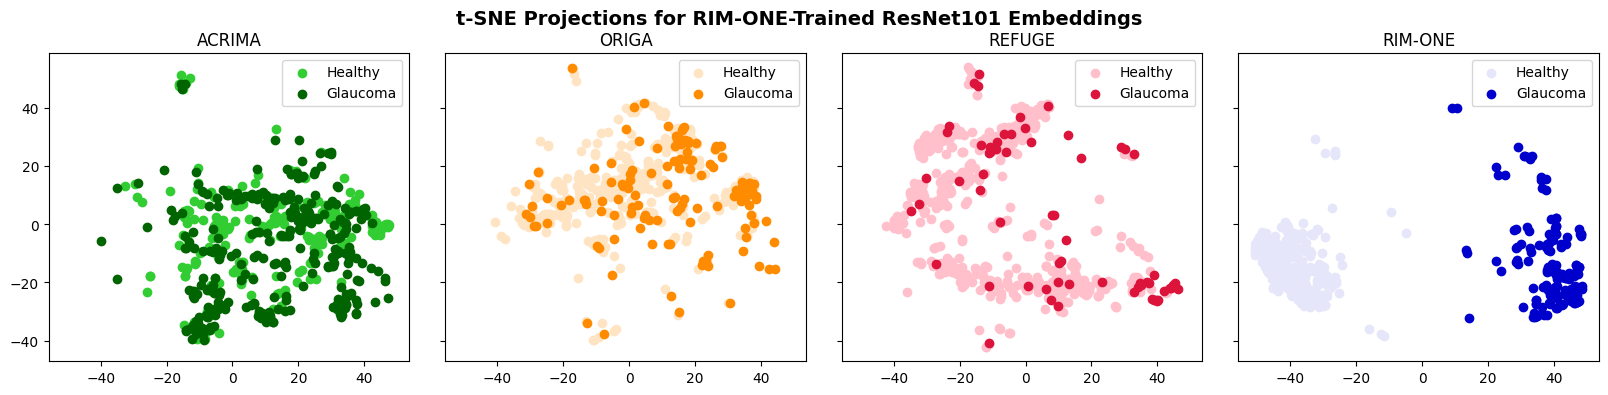

In [20]:
# Subplots for each dataset embedding
# [length of 0, length of 1 (total length)]: 250, 314 (564), 388, 132 (520), 580, 64 (644), 251, 141 (392)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20,4), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.1)

ax1.scatter(embed_tsne[0:249, 0], embed_tsne[0:249, 1], color='limegreen', label='Healthy')
ax1.scatter(embed_tsne[250:563, 0], embed_tsne[250:563, 1], color='darkgreen', label='Glaucoma')
ax1.set_title("ACRIMA")
ax1.legend()

ax2.scatter(embed_tsne[564:951, 0], embed_tsne[564:951, 1], color='bisque', label='Healthy')
ax2.scatter(embed_tsne[952:1083, 0], embed_tsne[952:1083, 1], color='darkorange', label='Glaucoma')
ax2.set_title("ORIGA")
ax2.legend()

ax3.scatter(embed_tsne[1084:1663, 0], embed_tsne[1084:1663, 1], color='pink', label='Healthy')
ax3.scatter(embed_tsne[1664:1727, 0], embed_tsne[1664:1727, 1], color='crimson', label='Glaucoma')
ax3.set_title("REFUGE")
ax3.legend()

ax4.scatter(embed_tsne[1728:1978, 0], embed_tsne[1728:1978, 1], color='lavender', label='Healthy')
ax4.scatter(embed_tsne[1979:2119, 0], embed_tsne[1979:2119, 1], color='mediumblue', label='Glaucoma')
ax4.set_title("RIM-ONE")
ax4.legend()

fig.suptitle("t-SNE Projections for " + finetuned + "-Trained ResNet101 Embeddings", y=0.99, fontsize=14, fontweight='bold')
plt.savefig('/content/drive/MyDrive/Thesis/t-SNE plots/' + finetuned + '_ResNet_concat.png')
plt.show()

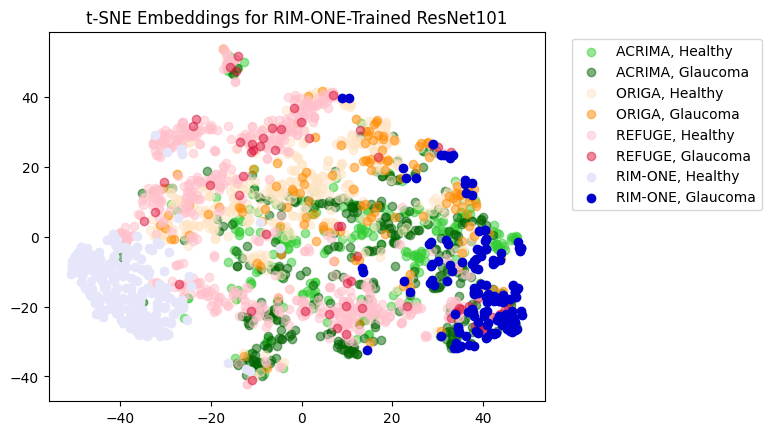

In [21]:
# All dataset embeddings overlaid on single plot

plt.scatter(embed_tsne[0:249, 0], embed_tsne[0:249, 1], color='limegreen', label='ACRIMA, Healthy', alpha=0.5)
plt.scatter(embed_tsne[250:563, 0], embed_tsne[250:563, 1], color='darkgreen', label='ACRIMA, Glaucoma', alpha=0.5)

plt.scatter(embed_tsne[564:951, 0], embed_tsne[564:951, 1], color='bisque', label='ORIGA, Healthy', alpha=0.5)
plt.scatter(embed_tsne[952:1083, 0], embed_tsne[952:1083, 1], color='darkorange', label='ORIGA, Glaucoma', alpha=0.5)

plt.scatter(embed_tsne[1084:1663, 0], embed_tsne[1084:1663, 1], color='pink', label='REFUGE, Healthy', alpha=0.5)
plt.scatter(embed_tsne[1664:1727, 0], embed_tsne[1664:1727, 1], color='crimson', label='REFUGE, Glaucoma', alpha=0.5)

plt.scatter(embed_tsne[1728:1978, 0], embed_tsne[1728:1978, 1], color='lavender', label='RIM-ONE, Healthy', alpha=1.0)
plt.scatter(embed_tsne[1979:2119, 0], embed_tsne[1979:2119, 1], color='mediumblue', label='RIM-ONE, Glaucoma', alpha=1.0)

plt.title("t-SNE Embeddings for " + finetuned + "-Trained ResNet101")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.savefig('/content/drive/MyDrive/Thesis/t-SNE plots/' + finetuned + '_ResNet_concat_overlay.png', bbox_inches='tight')
plt.show()

----------------------------------------------------------------------
**Finetuned YOLOv8**

In [2]:
# https://docs.ultralytics.com/modes/predict/
!pip install ultralytics
from ultralytics import YOLO

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.0/705.0 kB 5.1 MB/s eta 0:00:00


In [3]:
# dictionary of best finetuned models
paths = {'ACRIMA': '/content/drive/MyDrive/Thesis/trained_models/YOLOv8_ACRIMA_100eps_Jan26.pt',
         'ORIGA': '/content/drive/MyDrive/Thesis/trained_models/YOLOv8_ORIGA_100eps_Jan26.pt',
         'REFUGE': '/content/drive/MyDrive/Thesis/trained_models/YOLOv8_REFUGE_100eps_Jan26.pt',
         'RIM-ONE': '/content/drive/MyDrive/Thesis/trained_models/YOLOv8_RIM-ONE_100eps_Jan26.pt'}

In [49]:
# load model with best training weights
finetuned = 'ACRIMA'
best_path = paths[finetuned]
model = YOLO(best_path)

--------------------------------------------------
**All layers**

In [50]:
# Get length of all layers for embedding arrays
layer_dict = {}

train_dir = '/content/drive/MyDrive/Thesis/' + finetuned + '_ROI/train/'
train_data = ImageFolder(train_dir)

for i in range(9):
  img, label = train_data[0]
  results = model.predict(img, embed=[i])
  length = len(results[0])
  layer_dict[i] = length

In [51]:
# Get embeddings for each layer, all datasets
embed_dict = {}
tsne_dict = {}
tsne = TSNE(n_components=2)

sets = ['ACRIMA', 'ORIGA', 'REFUGE', 'RIM-ONE']

for dataset in sets:
  train_dir = '/content/drive/MyDrive/Thesis/' + dataset + '_ROI/train/'
  train_data = ImageFolder(train_dir)
  size = len(train_data)

  # create embedding dictionaries for each dataset
  embed_dict[dataset] = {}
  tsne_dict[dataset] = {}

  for layer in range(9):
    embed_arr = np.zeros((size, layer_dict[layer]))

    # get embedding for each image in dataset
    for i in range(size):
      img, label = train_data[i]
      results = model.predict(img, embed=[layer])
      embed_arr[i] = results[0]
      del results

    # add to embeddings dictionary
    embed_dict[dataset][layer] = embed_arr
    del embed_arr

    # perform t-SNE on each layer
    set_tsne = tsne.fit_transform(embed_dict[dataset][layer])
    tsne_dict[dataset][layer] = set_tsne
    del set_tsne

Streaming output truncated to the last 5000 lines.























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































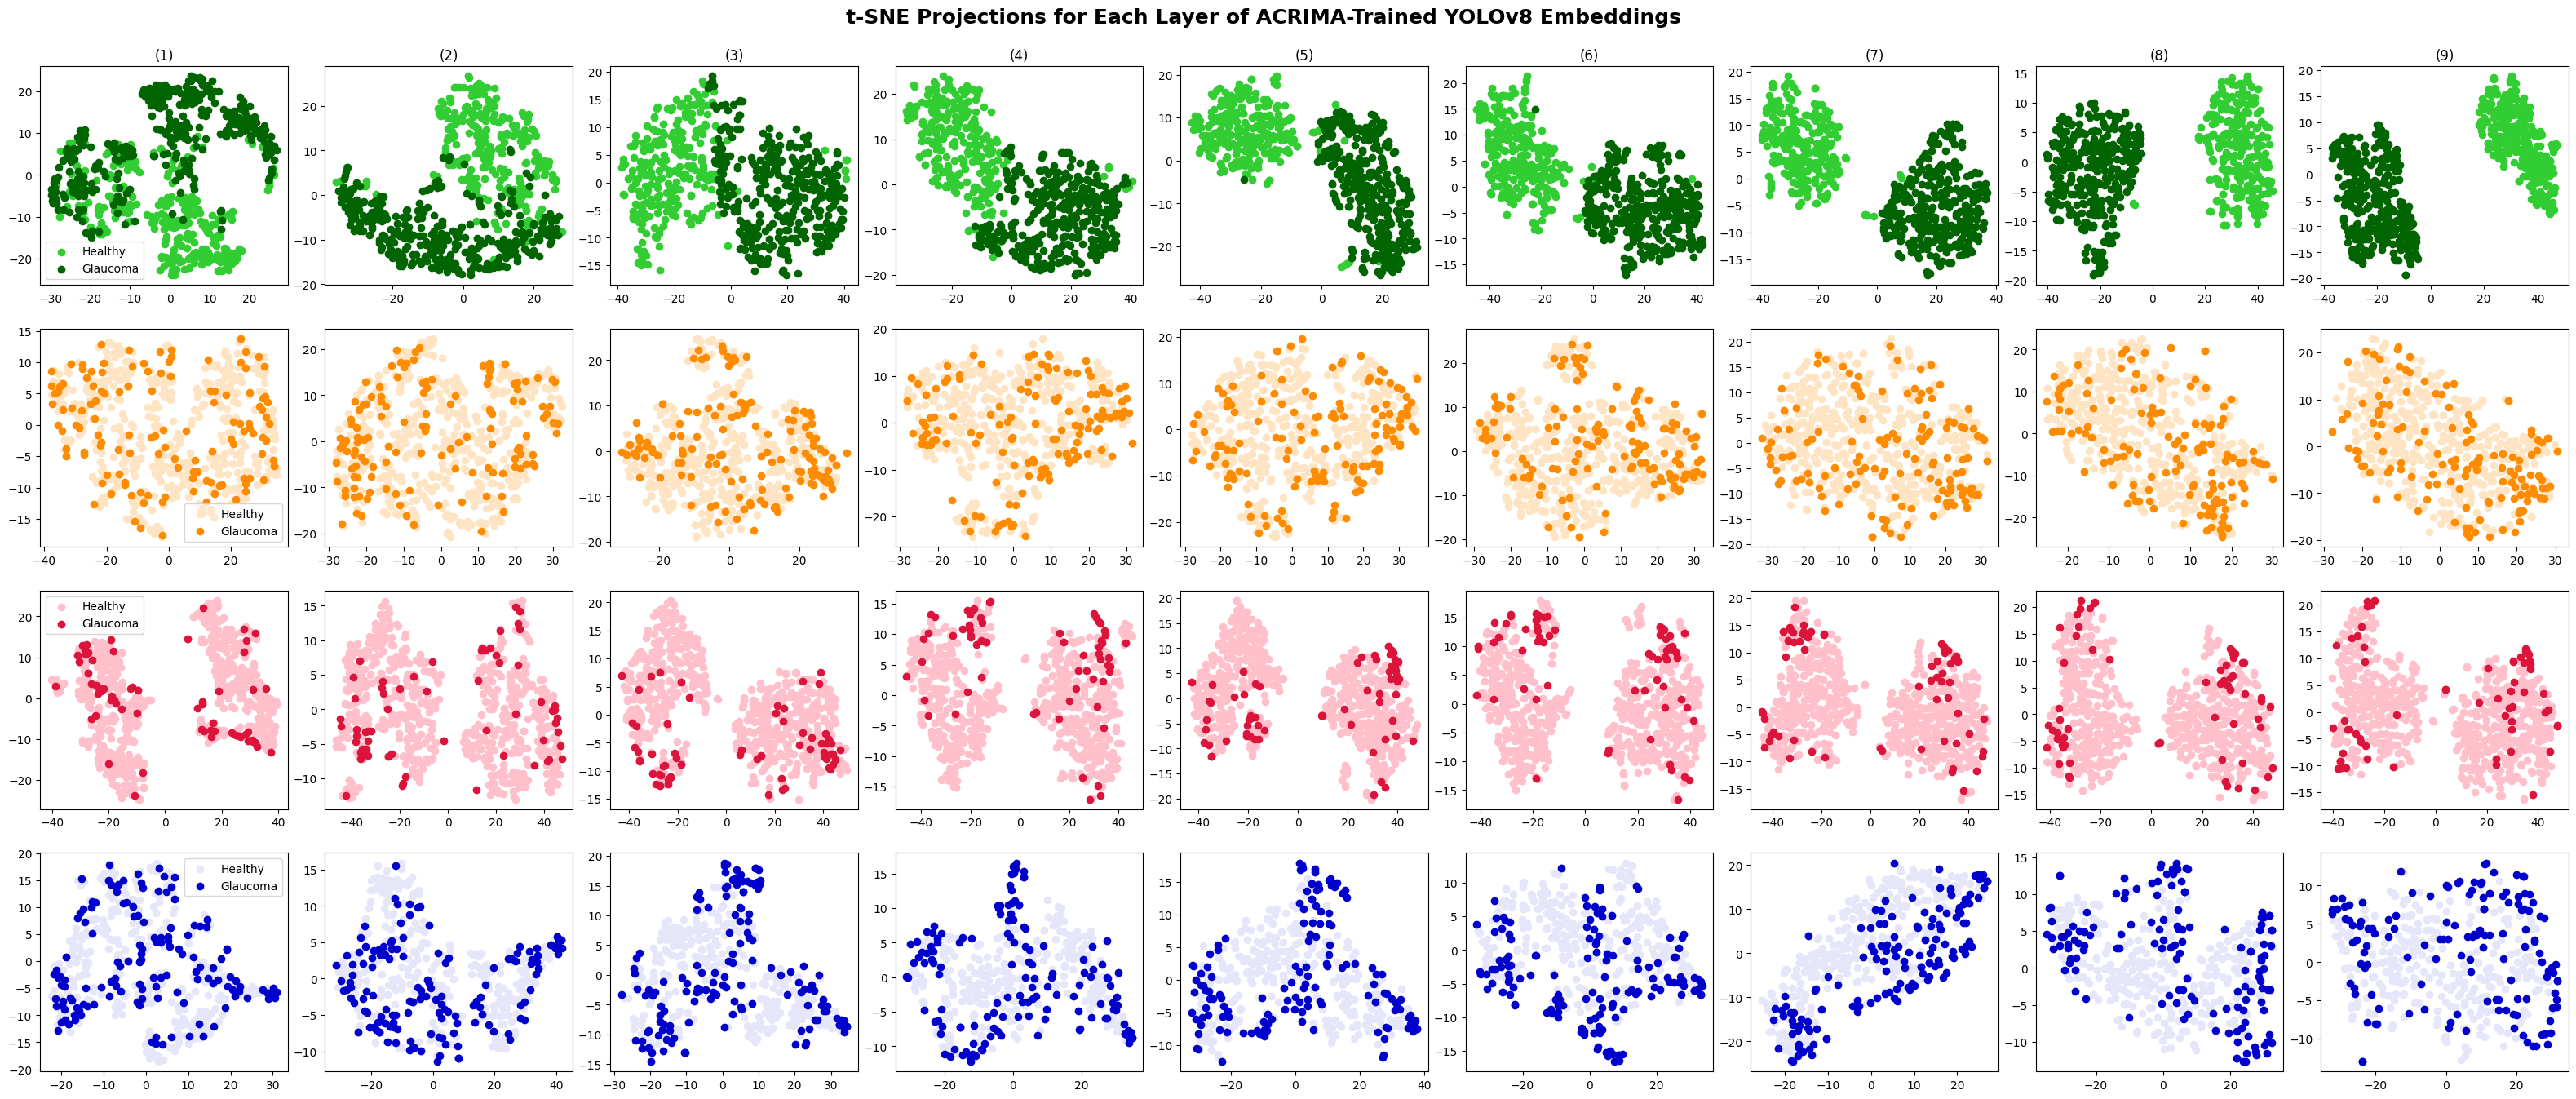

In [59]:
# Subplots for all layers, all datasets embeddings
# [length of 0, length of 1 (total length)]: 250, 314 (564), 388, 132 (520), 580, 64 (644), 251, 141 (392)

fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9),
 (ax10, ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18),
  (ax19, ax20, ax21, ax22, ax23, ax24, ax25, ax26, ax27),
   (ax28, ax29, ax30, ax31, ax32, ax33, ax34, ax35, ax36)) = plt.subplots(4,9, figsize=(40,16))
plt.subplots_adjust(wspace=0.15)

ax1.scatter(tsne_dict['ACRIMA'][0][0:249, 0], tsne_dict['ACRIMA'][0][0:249, 1], color='limegreen', label='Healthy')
ax1.scatter(tsne_dict['ACRIMA'][0][250:563, 0], tsne_dict['ACRIMA'][0][250:563, 1], color='darkgreen', label='Glaucoma')
ax1.set_title('(1)')
ax1.legend()

ax2.scatter(tsne_dict['ACRIMA'][1][0:249, 0], tsne_dict['ACRIMA'][1][0:249, 1], color='limegreen', label='Healthy')
ax2.scatter(tsne_dict['ACRIMA'][1][250:563, 0], tsne_dict['ACRIMA'][1][250:563, 1], color='darkgreen', label='Glaucoma')
ax2.set_title('(2)')

ax3.scatter(tsne_dict['ACRIMA'][2][0:249, 0], tsne_dict['ACRIMA'][2][0:249, 1], color='limegreen', label='Healthy')
ax3.scatter(tsne_dict['ACRIMA'][2][250:563, 0], tsne_dict['ACRIMA'][2][250:563, 1], color='darkgreen', label='Glaucoma')
ax3.set_title('(3)')

ax4.scatter(tsne_dict['ACRIMA'][3][0:249, 0], tsne_dict['ACRIMA'][3][0:249, 1], color='limegreen', label='Healthy')
ax4.scatter(tsne_dict['ACRIMA'][3][250:563, 0], tsne_dict['ACRIMA'][3][250:563, 1], color='darkgreen', label='Glaucoma')
ax4.set_title('(4)')

ax5.scatter(tsne_dict['ACRIMA'][4][0:249, 0], tsne_dict['ACRIMA'][4][0:249, 1], color='limegreen', label='Healthy')
ax5.scatter(tsne_dict['ACRIMA'][4][250:563, 0], tsne_dict['ACRIMA'][4][250:563, 1], color='darkgreen', label='Glaucoma')
ax5.set_title('(5)')

ax6.scatter(tsne_dict['ACRIMA'][5][0:249, 0], tsne_dict['ACRIMA'][5][0:249, 1], color='limegreen', label='Healthy')
ax6.scatter(tsne_dict['ACRIMA'][5][250:563, 0], tsne_dict['ACRIMA'][5][250:563, 1], color='darkgreen', label='Glaucoma')
ax6.set_title('(6)')

ax7.scatter(tsne_dict['ACRIMA'][6][0:249, 0], tsne_dict['ACRIMA'][6][0:249, 1], color='limegreen', label='Healthy')
ax7.scatter(tsne_dict['ACRIMA'][6][250:563, 0], tsne_dict['ACRIMA'][6][250:563, 1], color='darkgreen', label='Glaucoma')
ax7.set_title('(7)')

ax8.scatter(tsne_dict['ACRIMA'][7][0:249, 0], tsne_dict['ACRIMA'][7][0:249, 1], color='limegreen', label='Healthy')
ax8.scatter(tsne_dict['ACRIMA'][7][250:563, 0], tsne_dict['ACRIMA'][7][250:563, 1], color='darkgreen', label='Glaucoma')
ax8.set_title('(8)')

ax9.scatter(tsne_dict['ACRIMA'][8][0:249, 0], tsne_dict['ACRIMA'][8][0:249, 1], color='limegreen', label='Healthy')
ax9.scatter(tsne_dict['ACRIMA'][8][250:563, 0], tsne_dict['ACRIMA'][8][250:563, 1], color='darkgreen', label='Glaucoma')
ax9.set_title('(9)')


ax10.scatter(tsne_dict['ORIGA'][0][0:387, 0], tsne_dict['ORIGA'][0][0:387, 1], color='bisque', label='Healthy')
ax10.scatter(tsne_dict['ORIGA'][0][388:519, 0], tsne_dict['ORIGA'][0][388:519, 1], color='darkorange', label='Glaucoma')
ax10.legend()

ax11.scatter(tsne_dict['ORIGA'][1][0:387, 0], tsne_dict['ORIGA'][1][0:387, 1], color='bisque', label='Healthy')
ax11.scatter(tsne_dict['ORIGA'][1][388:519, 0], tsne_dict['ORIGA'][1][388:519, 1], color='darkorange', label='Glaucoma')

ax12.scatter(tsne_dict['ORIGA'][2][0:387, 0], tsne_dict['ORIGA'][2][0:387, 1], color='bisque', label='Healthy')
ax12.scatter(tsne_dict['ORIGA'][2][388:519, 0], tsne_dict['ORIGA'][2][388:519, 1], color='darkorange', label='Glaucoma')

ax13.scatter(tsne_dict['ORIGA'][3][0:387, 0], tsne_dict['ORIGA'][3][0:387, 1], color='bisque', label='Healthy')
ax13.scatter(tsne_dict['ORIGA'][3][388:519, 0], tsne_dict['ORIGA'][3][388:519, 1], color='darkorange', label='Glaucoma')

ax14.scatter(tsne_dict['ORIGA'][4][0:387, 0], tsne_dict['ORIGA'][4][0:387, 1], color='bisque', label='Healthy')
ax14.scatter(tsne_dict['ORIGA'][4][388:519, 0], tsne_dict['ORIGA'][4][388:519, 1], color='darkorange', label='Glaucoma')

ax15.scatter(tsne_dict['ORIGA'][5][0:387, 0], tsne_dict['ORIGA'][5][0:387, 1], color='bisque', label='Healthy')
ax15.scatter(tsne_dict['ORIGA'][5][388:519, 0], tsne_dict['ORIGA'][5][388:519, 1], color='darkorange', label='Glaucoma')

ax16.scatter(tsne_dict['ORIGA'][6][0:387, 0], tsne_dict['ORIGA'][6][0:387, 1], color='bisque', label='Healthy')
ax16.scatter(tsne_dict['ORIGA'][6][388:519, 0], tsne_dict['ORIGA'][6][388:519, 1], color='darkorange', label='Glaucoma')

ax17.scatter(tsne_dict['ORIGA'][7][0:387, 0], tsne_dict['ORIGA'][7][0:387, 1], color='bisque', label='Healthy')
ax17.scatter(tsne_dict['ORIGA'][7][388:519, 0], tsne_dict['ORIGA'][7][388:519, 1], color='darkorange', label='Glaucoma')

ax18.scatter(tsne_dict['ORIGA'][8][0:387, 0], tsne_dict['ORIGA'][8][0:387, 1], color='bisque', label='Healthy')
ax18.scatter(tsne_dict['ORIGA'][8][388:519, 0], tsne_dict['ORIGA'][8][388:519, 1], color='darkorange', label='Glaucoma')


ax19.scatter(tsne_dict['REFUGE'][0][0:579, 0], tsne_dict['REFUGE'][0][0:579, 1], color='pink', label='Healthy')
ax19.scatter(tsne_dict['REFUGE'][0][580:643, 0], tsne_dict['REFUGE'][0][580:643, 1], color='crimson', label='Glaucoma')
ax19.legend()

ax20.scatter(tsne_dict['REFUGE'][1][0:579, 0], tsne_dict['REFUGE'][1][0:579, 1], color='pink', label='Healthy')
ax20.scatter(tsne_dict['REFUGE'][1][580:643, 0], tsne_dict['REFUGE'][1][580:643, 1], color='crimson', label='Glaucoma')

ax21.scatter(tsne_dict['REFUGE'][2][0:579, 0], tsne_dict['REFUGE'][2][0:579, 1], color='pink', label='Healthy')
ax21.scatter(tsne_dict['REFUGE'][2][580:643, 0], tsne_dict['REFUGE'][2][580:643, 1], color='crimson', label='Glaucoma')

ax22.scatter(tsne_dict['REFUGE'][3][0:579, 0], tsne_dict['REFUGE'][3][0:579, 1], color='pink', label='Healthy')
ax22.scatter(tsne_dict['REFUGE'][3][580:643, 0], tsne_dict['REFUGE'][3][580:643, 1], color='crimson', label='Glaucoma')

ax23.scatter(tsne_dict['REFUGE'][4][0:579, 0], tsne_dict['REFUGE'][4][0:579, 1], color='pink', label='Healthy')
ax23.scatter(tsne_dict['REFUGE'][4][580:643, 0], tsne_dict['REFUGE'][4][580:643, 1], color='crimson', label='Glaucoma')

ax24.scatter(tsne_dict['REFUGE'][5][0:579, 0], tsne_dict['REFUGE'][5][0:579, 1], color='pink', label='Healthy')
ax24.scatter(tsne_dict['REFUGE'][5][580:643, 0], tsne_dict['REFUGE'][5][580:643, 1], color='crimson', label='Glaucoma')

ax25.scatter(tsne_dict['REFUGE'][6][0:579, 0], tsne_dict['REFUGE'][6][0:579, 1], color='pink', label='Healthy')
ax25.scatter(tsne_dict['REFUGE'][6][580:643, 0], tsne_dict['REFUGE'][6][580:643, 1], color='crimson', label='Glaucoma')

ax26.scatter(tsne_dict['REFUGE'][7][0:579, 0], tsne_dict['REFUGE'][7][0:579, 1], color='pink', label='Healthy')
ax26.scatter(tsne_dict['REFUGE'][7][580:643, 0], tsne_dict['REFUGE'][7][580:643, 1], color='crimson', label='Glaucoma')

ax27.scatter(tsne_dict['REFUGE'][8][0:579, 0], tsne_dict['REFUGE'][8][0:579, 1], color='pink', label='Healthy')
ax27.scatter(tsne_dict['REFUGE'][8][580:643, 0], tsne_dict['REFUGE'][8][580:643, 1], color='crimson', label='Glaucoma')


ax28.scatter(tsne_dict['RIM-ONE'][0][0:250, 0], tsne_dict['RIM-ONE'][0][0:250, 1], color='lavender', label='Healthy')
ax28.scatter(tsne_dict['RIM-ONE'][0][251:391, 0], tsne_dict['RIM-ONE'][0][251:391, 1], color='mediumblue', label='Glaucoma')
ax28.legend()

ax29.scatter(tsne_dict['RIM-ONE'][1][0:250, 0], tsne_dict['RIM-ONE'][1][0:250, 1], color='lavender', label='Healthy')
ax29.scatter(tsne_dict['RIM-ONE'][1][251:391, 0], tsne_dict['RIM-ONE'][1][251:391, 1], color='mediumblue', label='Glaucoma')

ax30.scatter(tsne_dict['RIM-ONE'][2][0:250, 0], tsne_dict['RIM-ONE'][2][0:250, 1], color='lavender', label='Healthy')
ax30.scatter(tsne_dict['RIM-ONE'][2][251:391, 0], tsne_dict['RIM-ONE'][2][251:391, 1], color='mediumblue', label='Glaucoma')

ax31.scatter(tsne_dict['RIM-ONE'][3][0:250, 0], tsne_dict['RIM-ONE'][3][0:250, 1], color='lavender', label='Healthy')
ax31.scatter(tsne_dict['RIM-ONE'][3][251:391, 0], tsne_dict['RIM-ONE'][3][251:391, 1], color='mediumblue', label='Glaucoma')

ax32.scatter(tsne_dict['RIM-ONE'][4][0:250, 0], tsne_dict['RIM-ONE'][4][0:250, 1], color='lavender', label='Healthy')
ax32.scatter(tsne_dict['RIM-ONE'][4][251:391, 0], tsne_dict['RIM-ONE'][4][251:391, 1], color='mediumblue', label='Glaucoma')

ax33.scatter(tsne_dict['RIM-ONE'][5][0:250, 0], tsne_dict['RIM-ONE'][5][0:250, 1], color='lavender', label='Healthy')
ax33.scatter(tsne_dict['RIM-ONE'][5][251:391, 0], tsne_dict['RIM-ONE'][5][251:391, 1], color='mediumblue', label='Glaucoma')

ax34.scatter(tsne_dict['RIM-ONE'][6][0:250, 0], tsne_dict['RIM-ONE'][6][0:250, 1], color='lavender', label='Healthy')
ax34.scatter(tsne_dict['RIM-ONE'][6][251:391, 0], tsne_dict['RIM-ONE'][6][251:391, 1], color='mediumblue', label='Glaucoma')

ax35.scatter(tsne_dict['RIM-ONE'][7][0:250, 0], tsne_dict['RIM-ONE'][7][0:250, 1], color='lavender', label='Healthy')
ax35.scatter(tsne_dict['RIM-ONE'][7][251:391, 0], tsne_dict['RIM-ONE'][7][251:391, 1], color='mediumblue', label='Glaucoma')

ax36.scatter(tsne_dict['RIM-ONE'][8][0:250, 0], tsne_dict['RIM-ONE'][8][0:250, 1], color='lavender', label='Healthy')
ax36.scatter(tsne_dict['RIM-ONE'][8][251:391, 0], tsne_dict['RIM-ONE'][8][251:391, 1], color='mediumblue', label='Glaucoma')

fig.suptitle("t-SNE Projections for Each Layer of " + finetuned + "-Trained YOLOv8 Embeddings", y=0.925, fontsize=18, fontweight='bold')
plt.savefig('/content/drive/MyDrive/Thesis/t-SNE plots/' + finetuned + '_YOLOv8_layers.png')
plt.show()

----------------------------------------------
**Final layer**

In [24]:
# get embedding from prediction
layer = 8

sets = ['ACRIMA', 'ORIGA', 'REFUGE', 'RIM-ONE']

embed_dict = {}
tsne_dict = {}
tsne = TSNE(n_components=2)

for dataset in sets:
  train_dir = '/content/drive/MyDrive/Thesis/' + dataset + '_ROI/train/'
  train_data = ImageFolder(train_dir)

  size = len(train_data)
  embed_arr = np.zeros((size, 256))

  # get embedding for each image in dataset
  for i in range(size):
    img, label = train_data[i]
    results = model.predict(img, embed=[layer])
    embed_arr[i] = results[0]
    del results

  # add to embeddings dictionary
  embed_dict[dataset] = embed_arr
  del embed_arr

  # perform t-SNE on each dataset separately
  set_tsne = tsne.fit_transform(embed_dict[dataset])
  tsne_dict[dataset] = set_tsne
  del set_tsne

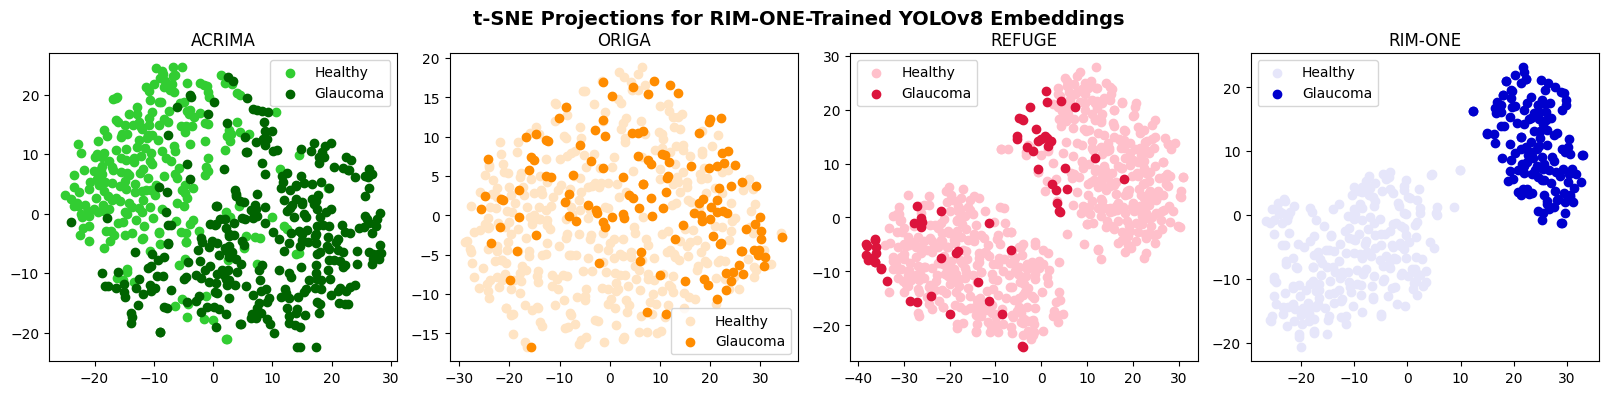

In [25]:
# Subplots for individual dataset embeddings
# [length of 0, length of 1 (total length)]: 250, 314 (564), 388, 132 (520), 580, 64 (644), 251, 141 (392)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20,4))
plt.subplots_adjust(wspace=0.15)

ax1.scatter(tsne_dict['ACRIMA'][0:249, 0], tsne_dict['ACRIMA'][0:249, 1], color='limegreen', label='Healthy')
ax1.scatter(tsne_dict['ACRIMA'][250:563, 0], tsne_dict['ACRIMA'][250:563, 1], color='darkgreen', label='Glaucoma')
ax1.set_title("ACRIMA")
ax1.legend()

ax2.scatter(tsne_dict['ORIGA'][0:387, 0], tsne_dict['ORIGA'][0:387, 1], color='bisque', label='Healthy')
ax2.scatter(tsne_dict['ORIGA'][388:519, 0], tsne_dict['ORIGA'][388:519, 1], color='darkorange', label='Glaucoma')
ax2.set_title("ORIGA")
ax2.legend()

ax3.scatter(tsne_dict['REFUGE'][0:579, 0], tsne_dict['REFUGE'][0:579, 1], color='pink', label='Healthy')
ax3.scatter(tsne_dict['REFUGE'][580:643, 0], tsne_dict['REFUGE'][580:643, 1], color='crimson', label='Glaucoma')
ax3.set_title("REFUGE")
ax3.legend()

ax4.scatter(tsne_dict['RIM-ONE'][0:250, 0], tsne_dict['RIM-ONE'][0:250, 1], color='lavender', label='Healthy')
ax4.scatter(tsne_dict['RIM-ONE'][251:391, 0], tsne_dict['RIM-ONE'][251:391, 1], color='mediumblue', label='Glaucoma')
ax4.set_title("RIM-ONE")
ax4.legend()

fig.suptitle("t-SNE Projections for " + finetuned + "-Trained YOLOv8 Embeddings", y=0.99, fontsize=14, fontweight='bold')
plt.savefig('/content/drive/MyDrive/Thesis/t-SNE plots/' + finetuned + '_YOLOv8.png')
plt.show()

In [26]:
# perform t-SNE on full concatenated array (all datasets)
full_embed_arr = np.concatenate((embed_dict['ACRIMA'], embed_dict['ORIGA'], embed_dict['REFUGE'], embed_dict['RIM-ONE']), axis=0)
embed_tsne = tsne.fit_transform(full_embed_arr)

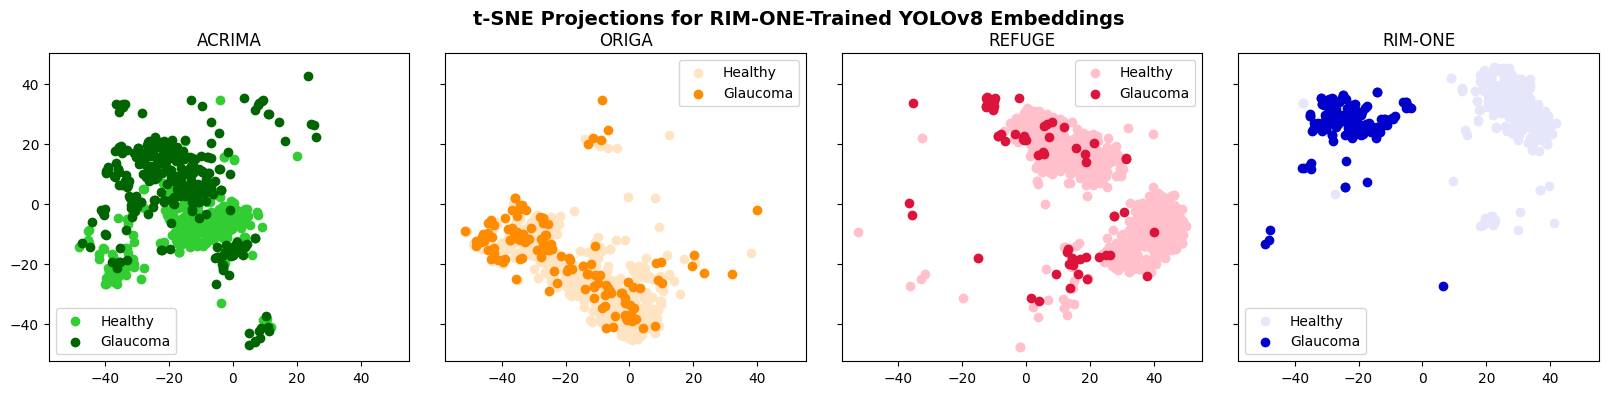

In [27]:
# Subplots for each dataset embedding
# [length of 0, length of 1 (total length)]: 250, 314 (564), 388, 132 (520), 580, 64 (644), 251, 141 (392)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20,4), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.1)

ax1.scatter(embed_tsne[0:249, 0], embed_tsne[0:249, 1], color='limegreen', label='Healthy')
ax1.scatter(embed_tsne[250:563, 0], embed_tsne[250:563, 1], color='darkgreen', label='Glaucoma')
ax1.set_title("ACRIMA")
ax1.legend()

ax2.scatter(embed_tsne[564:951, 0], embed_tsne[564:951, 1], color='bisque', label='Healthy')
ax2.scatter(embed_tsne[952:1083, 0], embed_tsne[952:1083, 1], color='darkorange', label='Glaucoma')
ax2.set_title("ORIGA")
ax2.legend()

ax3.scatter(embed_tsne[1084:1663, 0], embed_tsne[1084:1663, 1], color='pink', label='Healthy')
ax3.scatter(embed_tsne[1664:1727, 0], embed_tsne[1664:1727, 1], color='crimson', label='Glaucoma')
ax3.set_title("REFUGE")
ax3.legend()

ax4.scatter(embed_tsne[1728:1978, 0], embed_tsne[1728:1978, 1], color='lavender', label='Healthy')
ax4.scatter(embed_tsne[1979:2119, 0], embed_tsne[1979:2119, 1], color='mediumblue', label='Glaucoma')
ax4.set_title("RIM-ONE")
ax4.legend()

fig.suptitle("t-SNE Projections for " + finetuned + "-Trained YOLOv8 Embeddings", y=0.99, fontsize=14, fontweight='bold')
plt.savefig('/content/drive/MyDrive/Thesis/t-SNE plots/' + finetuned + '_YOLOv8_concat.png')
plt.show()

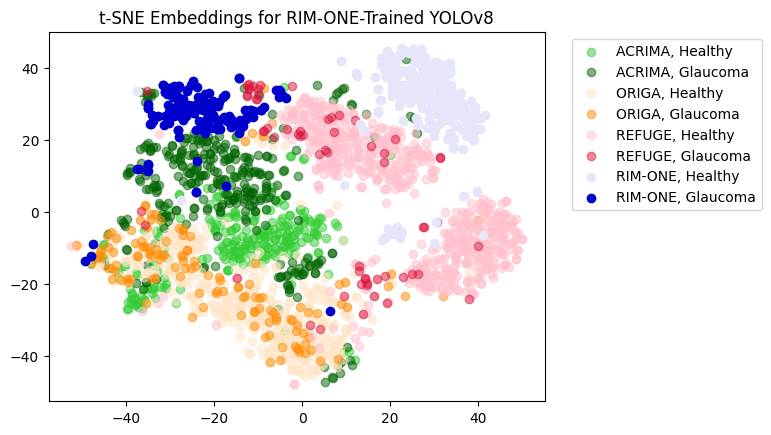

In [28]:
# All dataset embeddings overlaid on single plot

plt.scatter(embed_tsne[0:249, 0], embed_tsne[0:249, 1], color='limegreen', label='ACRIMA, Healthy', alpha=0.5)
plt.scatter(embed_tsne[250:563, 0], embed_tsne[250:563, 1], color='darkgreen', label='ACRIMA, Glaucoma', alpha=0.5)

plt.scatter(embed_tsne[564:951, 0], embed_tsne[564:951, 1], color='bisque', label='ORIGA, Healthy', alpha=0.5)
plt.scatter(embed_tsne[952:1083, 0], embed_tsne[952:1083, 1], color='darkorange', label='ORIGA, Glaucoma', alpha=0.5)

plt.scatter(embed_tsne[1084:1663, 0], embed_tsne[1084:1663, 1], color='pink', label='REFUGE, Healthy', alpha=0.5)
plt.scatter(embed_tsne[1664:1727, 0], embed_tsne[1664:1727, 1], color='crimson', label='REFUGE, Glaucoma', alpha=0.5)

plt.scatter(embed_tsne[1728:1978, 0], embed_tsne[1728:1978, 1], color='lavender', label='RIM-ONE, Healthy', alpha=1.0)
plt.scatter(embed_tsne[1979:2119, 0], embed_tsne[1979:2119, 1], color='mediumblue', label='RIM-ONE, Glaucoma', alpha=1.0)

plt.title("t-SNE Embeddings for " + finetuned + "-Trained YOLOv8")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.savefig('/content/drive/MyDrive/Thesis/t-SNE plots/' + finetuned + '_YOLOv8_concat_overlay.png', bbox_inches='tight')
plt.show()

-----------------------------------------------------------
**Raw images**


In [33]:
# Feature vectors of raw images
sets = ['ACRIMA', 'ORIGA', 'REFUGE', 'RIM-ONE']
embed_dict = {}

for dataset in sets:
  train_dir = '/content/drive/MyDrive/Thesis/' + dataset + '_ROI/train/'
  train_data = ImageFolder(train_dir, transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=datasets[dataset]['means'], std=datasets[dataset]['stds'])]))

  embed_arr = np.zeros((len(train_data), 3*224*224))

  for i in range(len(train_data)):
    img, label = train_data[i]
    embed_arr[i] = img.reshape(-1)

  embed_dict[dataset] = embed_arr
  del embed_arr

  # perform t-SNE on each dataset separately
  set_tsne = tsne.fit_transform(embed_dict[dataset])
  tsne_dict[dataset] = set_tsne
  del set_tsne

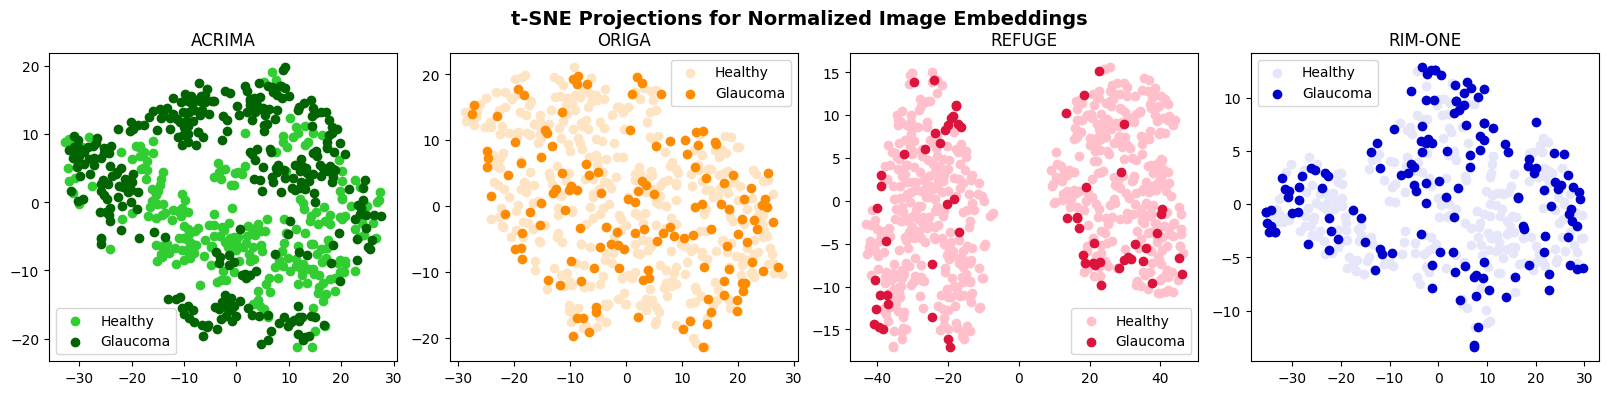

In [34]:
# Subplots for raw image embeddings, normalized by dataset
# [length of 0, length of 1 (total length)]: 250, 314 (564), 388, 132 (520), 580, 64 (644), 251, 141 (392)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20,4))
plt.subplots_adjust(wspace=0.15)

ax1.scatter(tsne_dict['ACRIMA'][0:249, 0], tsne_dict['ACRIMA'][0:249, 1], color='limegreen', label='Healthy')
ax1.scatter(tsne_dict['ACRIMA'][250:563, 0], tsne_dict['ACRIMA'][250:563, 1], color='darkgreen', label='Glaucoma')
ax1.set_title("ACRIMA")
ax1.legend()

ax2.scatter(tsne_dict['ORIGA'][0:387, 0], tsne_dict['ORIGA'][0:387, 1], color='bisque', label='Healthy')
ax2.scatter(tsne_dict['ORIGA'][388:519, 0], tsne_dict['ORIGA'][388:519, 1], color='darkorange', label='Glaucoma')
ax2.set_title("ORIGA")
ax2.legend()

ax3.scatter(tsne_dict['REFUGE'][0:579, 0], tsne_dict['REFUGE'][0:579, 1], color='pink', label='Healthy')
ax3.scatter(tsne_dict['REFUGE'][580:643, 0], tsne_dict['REFUGE'][580:643, 1], color='crimson', label='Glaucoma')
ax3.set_title("REFUGE")
ax3.legend()

ax4.scatter(tsne_dict['RIM-ONE'][0:250, 0], tsne_dict['RIM-ONE'][0:250, 1], color='lavender', label='Healthy')
ax4.scatter(tsne_dict['RIM-ONE'][251:391, 0], tsne_dict['RIM-ONE'][251:391, 1], color='mediumblue', label='Glaucoma')
ax4.set_title("RIM-ONE")
ax4.legend()

fig.suptitle("t-SNE Projections for Normalized Image Embeddings", y=0.99, fontsize=14, fontweight='bold')
plt.savefig('/content/drive/MyDrive/Thesis/t-SNE plots/Original_norm.png')
plt.show()

In [35]:
# perform t-SNE on full concatenated array (all datasets)
full_embed_arr = np.concatenate((embed_dict['ACRIMA'], embed_dict['ORIGA'], embed_dict['REFUGE'], embed_dict['RIM-ONE']), axis=0)
embed_tsne = tsne.fit_transform(full_embed_arr)

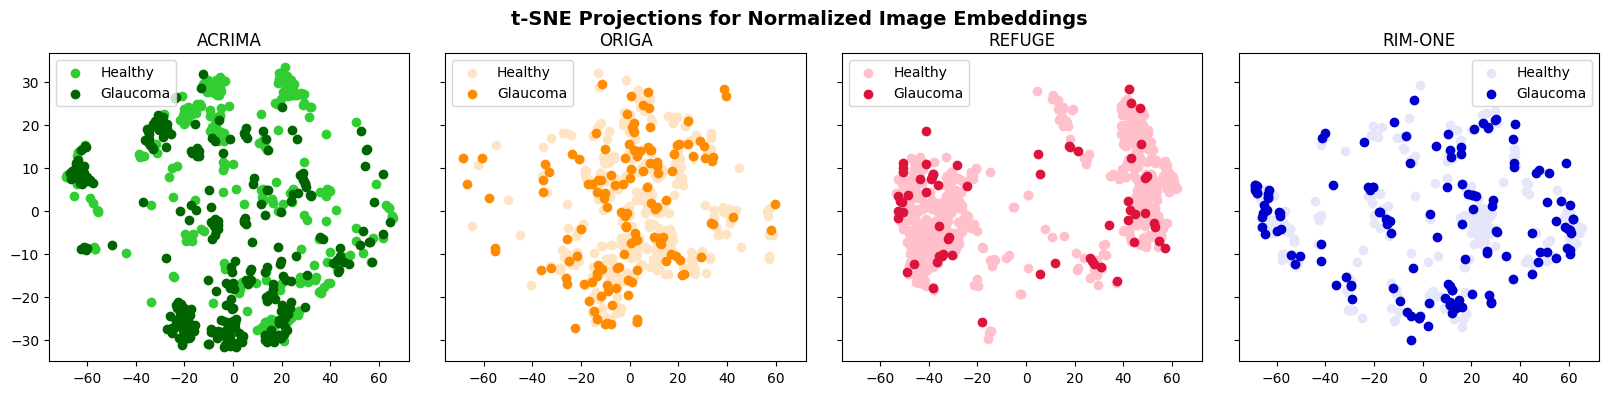

In [37]:
# Subplots for raw image embeddings, NOT normalized and concatenated
# [length of 0, length of 1 (total length)]: 250, 314 (564), 388, 132 (520), 580, 64 (644), 251, 141 (392)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20,4), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.1)

ax1.scatter(embed_tsne[0:249, 0], embed_tsne[0:249, 1], color='limegreen', label='Healthy')
ax1.scatter(embed_tsne[250:563, 0], embed_tsne[250:563, 1], color='darkgreen', label='Glaucoma')
ax1.set_title("ACRIMA")
ax1.legend()

ax2.scatter(embed_tsne[564:951, 0], embed_tsne[564:951, 1], color='bisque', label='Healthy')
ax2.scatter(embed_tsne[952:1083, 0], embed_tsne[952:1083, 1], color='darkorange', label='Glaucoma')
ax2.set_title("ORIGA")
ax2.legend()

ax3.scatter(embed_tsne[1084:1663, 0], embed_tsne[1084:1663, 1], color='pink', label='Healthy')
ax3.scatter(embed_tsne[1664:1727, 0], embed_tsne[1664:1727, 1], color='crimson', label='Glaucoma')
ax3.set_title("REFUGE")
ax3.legend()

ax4.scatter(embed_tsne[1728:1978, 0], embed_tsne[1728:1978, 1], color='lavender', label='Healthy')
ax4.scatter(embed_tsne[1979:2119, 0], embed_tsne[1979:2119, 1], color='mediumblue', label='Glaucoma')
ax4.set_title("RIM-ONE")
ax4.legend()

fig.suptitle("t-SNE Projections for Normalized Image Embeddings", y=0.99, fontsize=14, fontweight='bold')
plt.savefig('/content/drive/MyDrive/Thesis/t-SNE plots/Original_norm_concat.png')
plt.show()

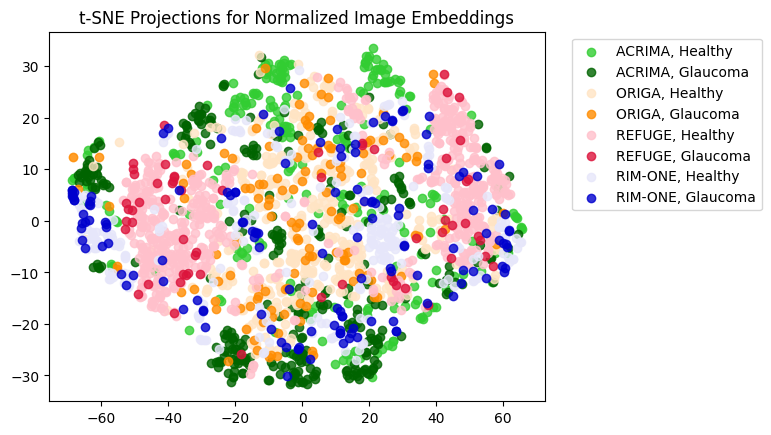

In [38]:
# All dataset embeddings overlaid on single plot

plt.scatter(embed_tsne[0:249, 0], embed_tsne[0:249, 1], color='limegreen', label='ACRIMA, Healthy', alpha=0.8)
plt.scatter(embed_tsne[250:563, 0], embed_tsne[250:563, 1], color='darkgreen', label='ACRIMA, Glaucoma', alpha=0.8)

plt.scatter(embed_tsne[564:951, 0], embed_tsne[564:951, 1], color='bisque', label='ORIGA, Healthy', alpha=0.8)
plt.scatter(embed_tsne[952:1083, 0], embed_tsne[952:1083, 1], color='darkorange', label='ORIGA, Glaucoma', alpha=0.8)

plt.scatter(embed_tsne[1084:1663, 0], embed_tsne[1084:1663, 1], color='pink', label='REFUGE, Healthy', alpha=0.8)
plt.scatter(embed_tsne[1664:1727, 0], embed_tsne[1664:1727, 1], color='crimson', label='REFUGE, Glaucoma', alpha=0.8)

plt.scatter(embed_tsne[1728:1978, 0], embed_tsne[1728:1978, 1], color='lavender', label='RIM-ONE, Healthy', alpha=0.8)
plt.scatter(embed_tsne[1979:2119, 0], embed_tsne[1979:2119, 1], color='mediumblue', label='RIM-ONE, Glaucoma', alpha=0.8)

plt.title("t-SNE Projections for Normalized Image Embeddings")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.savefig('/content/drive/MyDrive/Thesis/t-SNE plots/Original_norm_concat_overlay.png', bbox_inches='tight')
plt.show()

In [27]:
# Feature vectors of raw images
sets = ['ACRIMA', 'ORIGA', 'REFUGE', 'RIM-ONE']
embed_dict = {}

for dataset in sets:
  train_dir = '/content/drive/MyDrive/Thesis/' + dataset + '_ROI/train/'
  train_data = ImageFolder(train_dir, transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()]))

  embed_arr = np.zeros((len(train_data), 3*224*224))

  for i in range(len(train_data)):
    img, label = train_data[i]
    embed_arr[i] = img.reshape(-1)

  embed_dict[dataset] = embed_arr
  del embed_arr

  # perform t-SNE on each dataset separately
  set_tsne = tsne.fit_transform(embed_dict[dataset])
  tsne_dict[dataset] = set_tsne
  del set_tsne

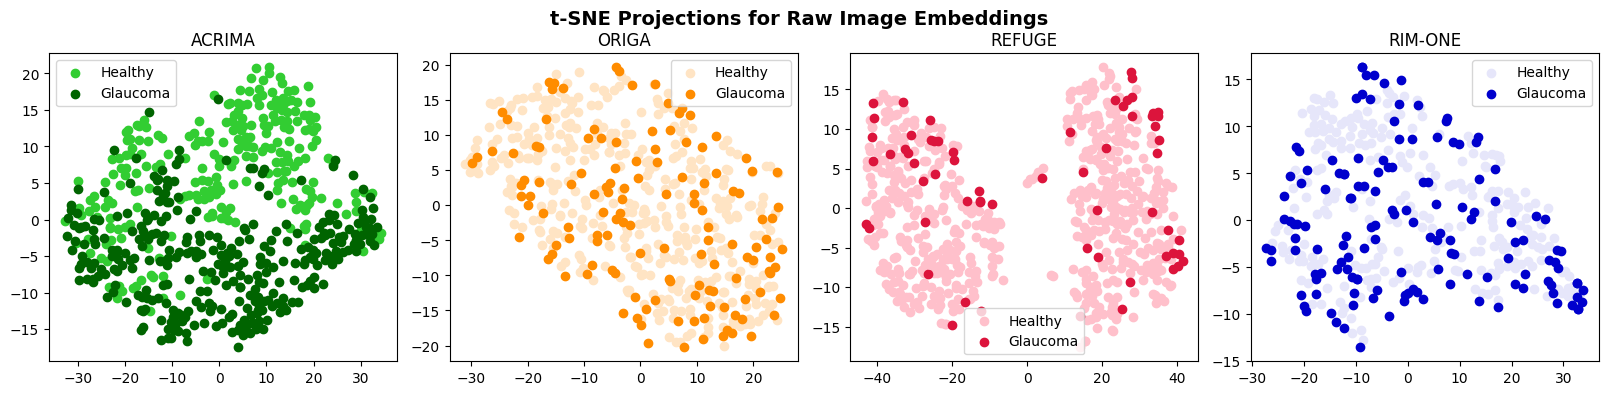

In [28]:
# Subplots for raw image embeddings, NOT normalized
# [length of 0, length of 1 (total length)]: 250, 314 (564), 388, 132 (520), 580, 64 (644), 251, 141 (392)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20,4))
plt.subplots_adjust(wspace=0.15)

ax1.scatter(tsne_dict['ACRIMA'][0:249, 0], tsne_dict['ACRIMA'][0:249, 1], color='limegreen', label='Healthy')
ax1.scatter(tsne_dict['ACRIMA'][250:563, 0], tsne_dict['ACRIMA'][250:563, 1], color='darkgreen', label='Glaucoma')
ax1.set_title("ACRIMA")
ax1.legend()

ax2.scatter(tsne_dict['ORIGA'][0:387, 0], tsne_dict['ORIGA'][0:387, 1], color='bisque', label='Healthy')
ax2.scatter(tsne_dict['ORIGA'][388:519, 0], tsne_dict['ORIGA'][388:519, 1], color='darkorange', label='Glaucoma')
ax2.set_title("ORIGA")
ax2.legend()

ax3.scatter(tsne_dict['REFUGE'][0:579, 0], tsne_dict['REFUGE'][0:579, 1], color='pink', label='Healthy')
ax3.scatter(tsne_dict['REFUGE'][580:643, 0], tsne_dict['REFUGE'][580:643, 1], color='crimson', label='Glaucoma')
ax3.set_title("REFUGE")
ax3.legend()

ax4.scatter(tsne_dict['RIM-ONE'][0:250, 0], tsne_dict['RIM-ONE'][0:250, 1], color='lavender', label='Healthy')
ax4.scatter(tsne_dict['RIM-ONE'][251:391, 0], tsne_dict['RIM-ONE'][251:391, 1], color='mediumblue', label='Glaucoma')
ax4.set_title("RIM-ONE")
ax4.legend()

fig.suptitle("t-SNE Projections for Raw Image Embeddings", y=0.99, fontsize=14, fontweight='bold')
plt.savefig('/content/drive/MyDrive/Thesis/t-SNE plots/Original.png')
plt.show()

In [29]:
# perform t-SNE on full concatenated array (all datasets)
full_embed_arr = np.concatenate((embed_dict['ACRIMA'], embed_dict['ORIGA'], embed_dict['REFUGE'], embed_dict['RIM-ONE']), axis=0)
embed_tsne = tsne.fit_transform(full_embed_arr)

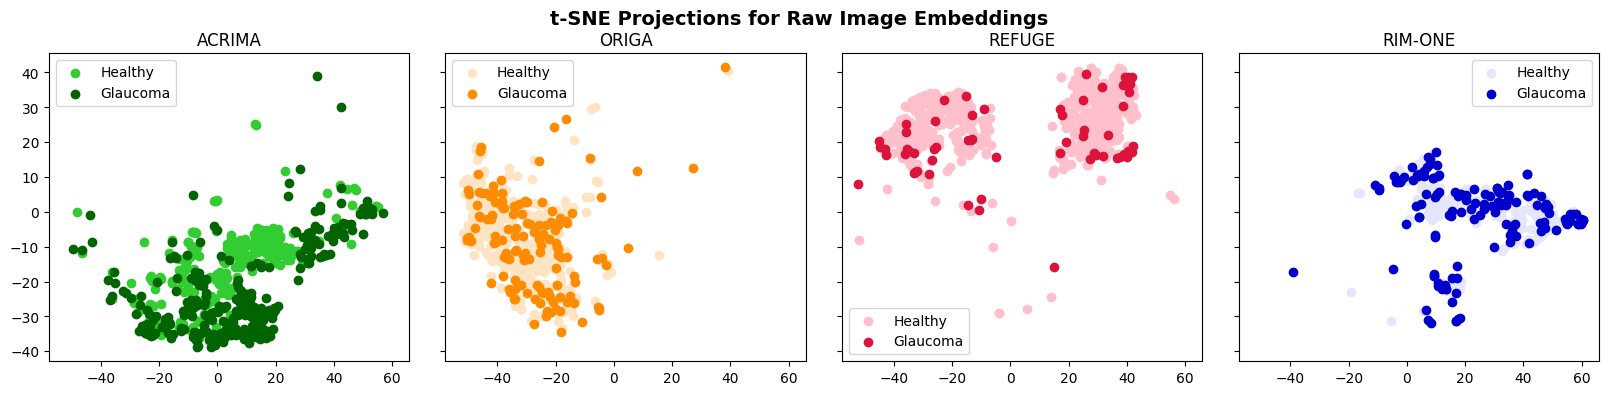

In [30]:
# Subplots for raw image embeddings, NOT normalized and concatenated
# [length of 0, length of 1 (total length)]: 250, 314 (564), 388, 132 (520), 580, 64 (644), 251, 141 (392)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20,4), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.1)

ax1.scatter(embed_tsne[0:249, 0], embed_tsne[0:249, 1], color='limegreen', label='Healthy')
ax1.scatter(embed_tsne[250:563, 0], embed_tsne[250:563, 1], color='darkgreen', label='Glaucoma')
ax1.set_title("ACRIMA")
ax1.legend()

ax2.scatter(embed_tsne[564:951, 0], embed_tsne[564:951, 1], color='bisque', label='Healthy')
ax2.scatter(embed_tsne[952:1083, 0], embed_tsne[952:1083, 1], color='darkorange', label='Glaucoma')
ax2.set_title("ORIGA")
ax2.legend()

ax3.scatter(embed_tsne[1084:1663, 0], embed_tsne[1084:1663, 1], color='pink', label='Healthy')
ax3.scatter(embed_tsne[1664:1727, 0], embed_tsne[1664:1727, 1], color='crimson', label='Glaucoma')
ax3.set_title("REFUGE")
ax3.legend()

ax4.scatter(embed_tsne[1728:1978, 0], embed_tsne[1728:1978, 1], color='lavender', label='Healthy')
ax4.scatter(embed_tsne[1979:2119, 0], embed_tsne[1979:2119, 1], color='mediumblue', label='Glaucoma')
ax4.set_title("RIM-ONE")
ax4.legend()

fig.suptitle("t-SNE Projections for Raw Image Embeddings", y=0.99, fontsize=14, fontweight='bold')
plt.savefig('/content/drive/MyDrive/Thesis/t-SNE plots/Original_concat.png')
plt.show()

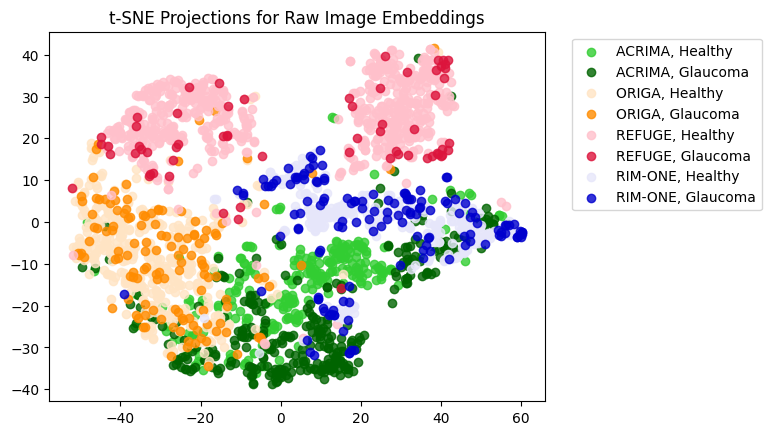

In [31]:
# All dataset embeddings overlaid on single plot

plt.scatter(embed_tsne[0:249, 0], embed_tsne[0:249, 1], color='limegreen', label='ACRIMA, Healthy', alpha=0.8)
plt.scatter(embed_tsne[250:563, 0], embed_tsne[250:563, 1], color='darkgreen', label='ACRIMA, Glaucoma', alpha=0.8)

plt.scatter(embed_tsne[564:951, 0], embed_tsne[564:951, 1], color='bisque', label='ORIGA, Healthy', alpha=0.8)
plt.scatter(embed_tsne[952:1083, 0], embed_tsne[952:1083, 1], color='darkorange', label='ORIGA, Glaucoma', alpha=0.8)

plt.scatter(embed_tsne[1084:1663, 0], embed_tsne[1084:1663, 1], color='pink', label='REFUGE, Healthy', alpha=0.8)
plt.scatter(embed_tsne[1664:1727, 0], embed_tsne[1664:1727, 1], color='crimson', label='REFUGE, Glaucoma', alpha=0.8)

plt.scatter(embed_tsne[1728:1978, 0], embed_tsne[1728:1978, 1], color='lavender', label='RIM-ONE, Healthy', alpha=0.8)
plt.scatter(embed_tsne[1979:2119, 0], embed_tsne[1979:2119, 1], color='mediumblue', label='RIM-ONE, Glaucoma', alpha=0.8)

plt.title("t-SNE Projections for Raw Image Embeddings")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.savefig('/content/drive/MyDrive/Thesis/t-SNE plots/Original_concat_overlay.png', bbox_inches='tight')
plt.show()